In [1]:
import pandas as pd
from ast import literal_eval
from collections import Counter
import collections
import matplotlib.pylab as plt
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import operator

In [2]:
profiles = pd.read_csv("linkedin_profiles.csv")

profiles.experiences = profiles.experiences.apply(literal_eval)
profiles.educations = profiles.educations.apply(literal_eval)
profiles.licenses_and_certificates = profiles.licenses_and_certificates.apply(literal_eval)
profiles.skills = profiles.skills.apply(literal_eval)

In [3]:
profiles.head()

,name,headline,location,no_of_connections,about,experiences,educations,licenses_and_certificates,skills
0,Nikita Gupta,Data Analyst at TBWA\The Disruption Company | ...,Singapore,500+ connections,"I am currently at TBWA,Singapore helping adver...","[{'title': 'Data Analyst', 'company': 'TBWA\ G...","[{'school': 'Singapore Management University',...",[{'name': 'DoubleClick Campaign Manager Fundam...,"[Databases, Business Analysis, Data Structures..."
1,Jayden Ho,Senior Data Analyst at Publicis Singapore,Singapore,339 connections,Uncovering insights and trends for the consume...,"[{'title': 'Senior Data Analyst, Strategy', 'c...","[{'school': 'RMIT University', 'type': 'Bachel...","[{'name': 'Intro to SQL for Data Science', 'pr...","[Business Analytics, Data Visualization, Socia..."
2,Timothy Ong,Senior Data Analyst at Shopee,Singapore,463 connections,Timothy has a huge passion for data analytics....,"[{'title': 'Senior Data Analyst', 'company': '...","[{'school': 'Singapore Management University',...","[{'name': 'Six Sigma Green Belt', 'provider': ...",[]
3,Zi Lin,Data Analyst at GovTech,Singapore,147 connections,• Lead a team of 20+ patrol officers at a Neig...,"[{'title': 'Data Analyst, Data Science & Artif...","[{'school': 'Harvard University', 'type': 'Mas...","[{'name': 'Exploratory Data Analysis', 'provid...","[R, Investigation, Statistical Data Analysis, ..."
4,Minghao Liu,Data Analyst at Energy Aspects,Singapore,307 connections,mining and deep learning.,"[{'title': 'Data Analyst', 'company': 'Energy ...",[{'school': 'National University of Singapore'...,"[{'name': '计算导论与C语言基础', 'provider': 'Coursera'...","[SQL, R, Python, Data Analysis, Data Mining, M..."


### Total Number of Profiles

In [7]:
print(len(profiles))

534


### Connections Distribution

In [12]:
no_of_connections_raw = profiles["no_of_connections"].tolist()

In [21]:
def remove_connections_word(text):
    text = text.replace(' connections', '')
    text = text.replace(' connection', '')
    text = text.replace('500+', str(501))
    return text

In [22]:
no_of_connections = [remove_connections_word(item) for item in no_of_connections_raw]

In [24]:
no_of_connections[:5]

['501', '339', '463', '147', '307']

In [81]:
def convert_to_range(connection):
    if int(connection) <= 50:
        return "0-50"
    elif int(connection) > 50 and int(connection) <= 100:
        return "51-100"
    elif int(connection) > 100 and int(connection) <= 150:
        return "101-150"
    elif int(connection) > 150 and int(connection) <= 200:
        return "151-200"
    elif int(connection) > 200 and int(connection) <= 250:
        return "201-250"
    elif int(connection) > 250 and int(connection) <= 300:
        return "251-300"
    elif int(connection) > 300 and int(connection) <= 350:
        return "301-350"
    elif int(connection) > 350 and int(connection) <= 400:
        return "351-400"
    elif int(connection) > 400 and int(connection) <= 450:
        return "401-450"
    elif int(connection) > 450 and int(connection) <= 500:
        return "451-500"
    else:
        return "501+"

In [82]:
no_of_connections_range = [convert_to_range(item) for item in no_of_connections]

In [83]:
no_of_connections_range[:5]

['501+', '301-350', '451-500', '101-150', '301-350']

In [84]:
connections_count = Counter(no_of_connections_range)

In [85]:
connections_count

Counter({'501+': 275,
         '301-350': 26,
         '451-500': 20,
         '101-150': 26,
         '401-450': 20,
         '251-300': 25,
         '151-200': 41,
         '351-400': 35,
         '51-100': 25,
         '201-250': 27,
         '0-50': 14})

In [86]:
connections_count_list = sorted(connections_count.items())
x, y = zip(*connections_count_list)

In [87]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(x))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 10, 5
    plt.bar(index, y)
    plt.xlabel('Number of Connections', fontsize=10)
    plt.xticks(index, x, fontsize=10, rotation=30)
    plt.title('Connections Distribution')
    plt.show()

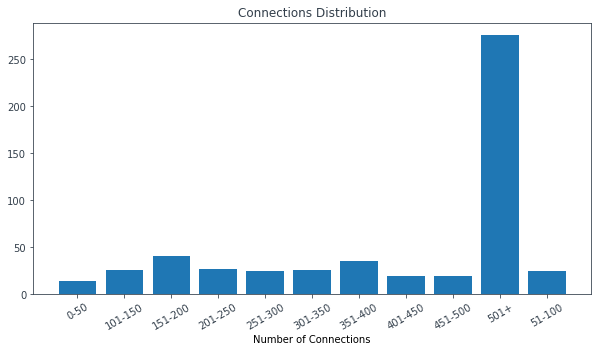

In [175]:
plot_bar_x()

### WordCloud on Headline and About Section

In [113]:
# COMBINE ALL HEADLINE AND ABOUT SECTIONS INTO ONE STRING
headline_combined = " ".join(str(headline) for headline in profiles.headline)
about_combined = " ".join(str(about) for about in profiles.about)
print ("There are {} words in the combination of all headline sections.".format(len(headline_combined)))
print ("There are {} words in the combination of all about sections.".format(len(about_combined)))

combined_text = headline_combined + " " + about_combined

There are 21637 words in the combination of all headline sections.
There are 321850 words in the combination of all about sections.


In [124]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Singapore", "data", "analyst", "scientist", "analysis", "analyst", "science", "machine", "learning", "analytic", "analytics"])

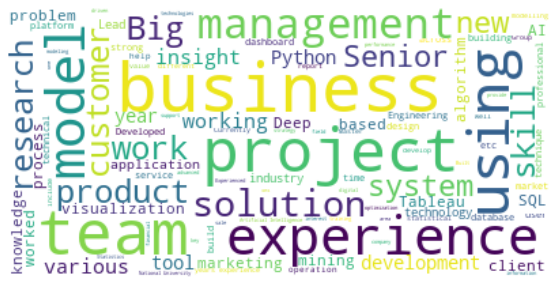

In [125]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(combined_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Education Distribution

In [45]:
all_educations = profiles['educations']

In [46]:
all_schools = []
all_types = []
all_courses = []

for educations in all_educations:
    for education in educations:
        try:
            all_schools.append(education['school'])
        except:
            all_schools.append("Nil")
        try:
            all_types.append(education['type'])
        except:
            all_types.append("Nil")
        try:
            all_courses.append(education['course'])
        except:
            all_courses.append("Nil")

In [228]:
all_schools_count = Counter(all_schools)
all_schools_count_sorted = sorted(all_schools_count.items(), key=lambda kv: kv[1])

In [233]:
all_schools_count_sorted

[('Jaypee Institute of Information Technology', 1),
 ('Technische Universität München', 1),
 ('Harvard University', 1),
 ('HBX | Harvard Business School', 1),
 ('Nanyang Junior college', 1),
 ("Xi'an Jiaotong University", 1),
 ('Stockholm School of Economics', 1),
 ('Higher School of Economics', 1),
 ('IEDC-Poslovna šola Bled', 1),
 ('The University of Queensland', 1),
 ('HEC School of Management / HEC Paris', 1),
 ('London School of Economics and Political Science', 1),
 ('Melbourne Business School', 1),
 ('Raffles Junior College, Singapore', 1),
 ('ZHAW School of Management and Law', 1),
 ('National Institute of Education, Singapore', 1),
 ('University of Leeds', 1),
 ('ACCA', 1),
 ('Oxford Brookes University', 1),
 ('LNMIIT', 1),
 ('Hogeschool Inholland / Inholland University of Applied Sciences', 1),
 ('Anglo Chinese School (Independent)', 1),
 ('MITx on edX', 1),
 ('SMA Santo Aloysius Bandung', 1),
 ('Carnegie Mellon University - Tepper School of Business', 1),
 ('Renmin Universit

In [241]:
schools = []
schools_count = []
for item in all_schools_count_sorted:
    if item[1] > 5:
        schools.append(item[0])
        schools_count.append(item[1])

In [242]:
print(schools[:5])
print(schools_count[:5])

['RMIT University', 'Meridian Junior College', 'The Hong Kong University of Science and Technology', 'National Junior College', 'The Australian National University']
[6, 6, 6, 6, 6]


In [243]:
def plot_bar_schools():
    # this is for plotting purpose
    index = np.arange(len(schools))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, schools_count)
    plt.xlabel('Schools', fontsize=10)
    plt.xticks(index, schools, fontsize=8, rotation=90)
    plt.title('Schools Distribution')
    plt.show()

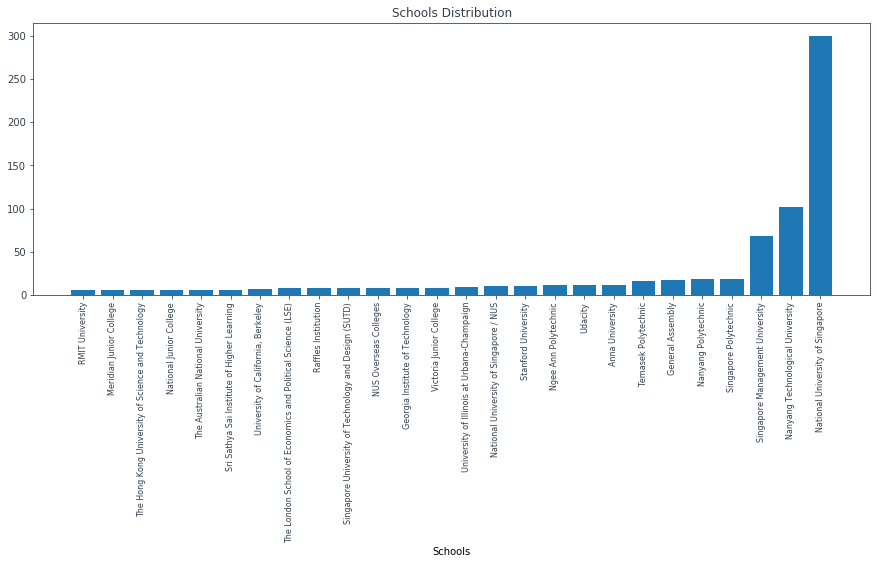

In [244]:
plot_bar_schools()

In [48]:
all_courses

['Nil',
 'Computer Science and Engineering',
 'Nil',
 'Nil',
 'Marketing',
 'Specialist Diploma in Business & Big Data Analytics',
 'Retail & Travel Management',
 '1st Major: Finance, 2nd Major: Operation Management',
 'Data Science',
 'Nil',
 'Statistics',
 'Econometrics and Mathematical Economics',
 'Nil',
 'Nil',
 'Statistics',
 'Statistics (specialization in business and finance)',
 'Big Data',
 'Analytics',
 'Nil',
 'Software Development',
 'Master of IT in Business (Analytics)',
 'Accounting',
 'Science',
 'Business Analytics and Information Technology',
 'Science Stream',
 'Industrial Systems Engineering & Management',
 'Mechanical Engineering',
 'Business and Economics with specialization in Management',
 'Economics with specialization in Corporate Finance',
 'Management',
 'Statistics and Economics',
 'Nil',
 'Computer Software Engineering',
 'Computer Software Engineering',
 'Software Engineering',
 'Data Science Immersive',
 'Nil',
 'Accounting and Finance',
 'Economics',
 '

### Experiences

In [18]:
all_experiences = profiles['experiences']

In [27]:
all_experiences[:5]

0    [{'title': 'Data Analyst', 'company': 'TBWA\ G...
1    [{'title': 'Senior Data Analyst, Strategy', 'c...
2    [{'title': 'Senior Data Analyst', 'company': '...
3    [{'title': 'Data Analyst, Data Science & Artif...
4    [{'title': 'Data Analyst', 'company': 'Energy ...
Name: experiences, dtype: object

In [26]:
all_current_titles = []
for experience in all_experiences:
    try:
        all_current_titles.append(experience[0]['title'])
    except:
        all_current_titles.append("Nil")

In [28]:
all_current_titles[:5]

['Data Analyst',
 'Senior Data Analyst, Strategy',
 'Senior Data Analyst',
 'Data Analyst, Data Science & Artificial Intelligence Division',
 'Data Analyst']

In [13]:
all_titles_count = Counter(all_current_titles)

In [15]:
len(all_titles_count)

207

In [29]:
all_current_companies = []
for experience in all_experiences:
    try:
        all_current_companies.append(experience[0]['company'])
    except:
        all_current_companies.append("Nil")

In [30]:
all_current_companies[:5]

['TBWA\\ Group Singapore',
 'Publicis Singapore',
 'Shopee',
 'GovTech Singapore',
 'Energy Aspects']

In [33]:
all_companies_count = Counter(all_current_companies)
all_companies_count_sorted = sorted(all_companies_count.items(), key=lambda kv: kv[1])

In [34]:
all_companies_count_sorted

[('TBWA\\ Group Singapore', 1),
 ('Publicis Singapore', 1),
 ('Energy Aspects', 1),
 ('Levi Strauss & Co.', 1),
 ('CARIUMA', 1),
 ('Fundnel Limited', 1),
 ('Changi Airport Group', 1),
 ('ExxonMobil', 1),
 ('JurongHealth Campus', 1),
 ('Viki, Inc.', 1),
 ('Credit Suisse', 1),
 ('Circles.Life', 1),
 ('MG Asia', 1),
 ('MoneySmart Group', 1),
 ('Ministry of Education, Singapore (MOE)', 1),
 ('CIMB', 1),
 ('ST Electronics (Info-Software Systems) Pte. Ltd.', 1),
 ('Yuanfudao', 1),
 ('Wipro Limited', 1),
 ('Sompo Holdings (Asia)', 1),
 ('GREAT EASTERN', 1),
 ('Hewlett Packard Enterprise', 1),
 ('Total eBiz Solutions Pte Ltd', 1),
 ('MOH Holdings Pte Ltd (Singapore)', 1),
 ('Ebiquity plc', 1),
 ('Apple', 1),
 ('Wilmar International', 1),
 ('Trakomatic Pte Ltd', 1),
 ('Ascendas-Singbridge', 1),
 ('bitwallet', 1),
 ('B2B Gene', 1),
 ('TripAdvisor', 1),
 ('Citibank NA', 1),
 ('Ogilvy', 1),
 ('ESET', 1),
 ('Sephora SEA', 1),
 ('DataSpark', 1),
 ('Course5i', 1),
 ('PSA Singapore', 1),
 ('SIM Global

In [38]:
companies = []
companies_count = []
for item in all_companies_count_sorted:
    if item[1] > 2:
        companies.append(item[0])
        companies_count.append(item[1])

In [39]:
print(companies[:5])
print(companies_count[:5])

['Microsoft', 'Aon Centre for Innovation and Analytics (ACIA)', 'HOOQ', 'AXA', 'NCS Group']
[3, 3, 3, 3, 3]


In [43]:
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(companies))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, companies_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, companies, fontsize=8, rotation=90)
    plt.title('Company Distribution')
    plt.show()

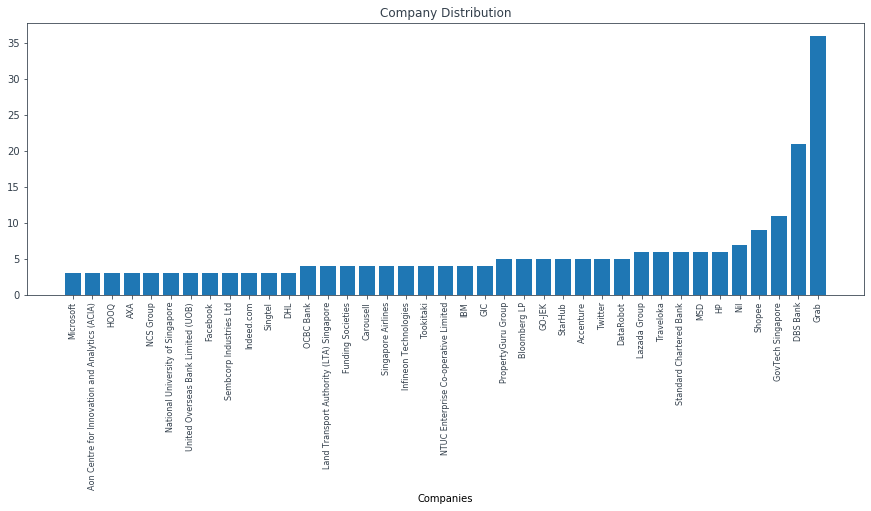

In [44]:
plot_bar_companies()

### Skills Distribution

In [134]:
all_skills = profiles['skills']

In [135]:
all_skills[:5]

0    [Databases, Business Analysis, Data Structures...
1    [Business Analytics, Data Visualization, Socia...
2                                                   []
3    [R, Investigation, Statistical Data Analysis, ...
4    [SQL, R, Python, Data Analysis, Data Mining, M...
Name: skills, dtype: object

In [136]:
all_skills_expanded = []
for skills in all_skills:
    for skill in skills:
        all_skills_expanded.append(skill)
        
all_skills_expanded[:10]

['Databases',
 'Business Analysis',
 'Data Structures',
 'Analytical Skills',
 'Project Management',
 'Event Management',
 'Data Analysis',
 'Market Analysis',
 'Management Consulting',
 'Web Analytics']

In [140]:
skills_count = Counter(all_skills_expanded)

In [165]:
skills_count_sorted = sorted(skills_count.items(), key=lambda kv: kv[1])

In [206]:
skills = []
skills_count = []
for item in skills_count_sorted:
    if item[1] > 30:
        skills.append(item[0])
        skills_count.append(item[1])

In [207]:
print(skills[:5])
print(skills_count[:5])

['Natural Language Processing (NLP)', 'Time Series Analysis', 'Requirements Analysis', 'Strategy', 'Customer Service']
[31, 31, 32, 32, 32]


In [214]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, skills, fontsize=8, rotation=90)
    plt.title('Skills Distribution')
    plt.show()

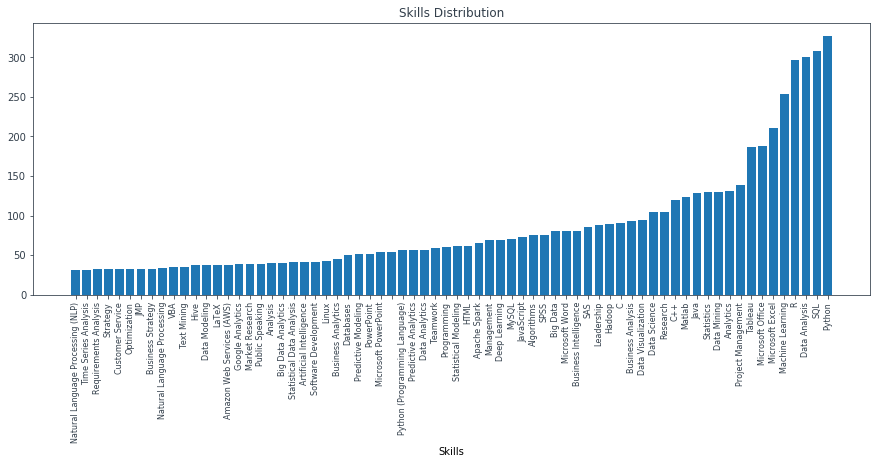

In [215]:
plot_bar_skills()

### Licenses and Certificates

In [49]:
all_lanc = profiles['licenses_and_certificates']

In [50]:
all_lanc.head()

0    [{'name': 'DoubleClick Campaign Manager Fundam...
1    [{'name': 'Intro to SQL for Data Science', 'pr...
2    [{'name': 'Six Sigma Green Belt', 'provider': ...
3    [{'name': 'Exploratory Data Analysis', 'provid...
4    [{'name': '计算导论与C语言基础', 'provider': 'Coursera'...
Name: licenses_and_certificates, dtype: object

In [58]:
all_lanc_expanded = []
for lancs in all_lanc:
    for lanc in lancs:
        try:
            all_lanc_expanded.append(lanc['name'] + " --> " + lanc['provider'])
        except:
            all_lanc_expanded.append("Nil")

In [59]:
all_lanc_expanded[:5]

['DoubleClick Campaign Manager Fundamentals --> DoubleClick',
 'DoubleClick Bid Manager Fundamentals | 87% --> DoubleClick',
 'R Programming,Grade Achieved: 97.0% --> Coursera Course Certificates',
 'AMCAT Certified in English Comprehension --> Aspiring Minds',
 'AMCAT Certified Business Analyst --> Aspiring Minds']

In [60]:
all_lanc_count = Counter(all_lanc_expanded)
all_lanc_count_sorted = sorted(all_lanc_count.items(), key=lambda kv: kv[1])

In [70]:
all_lanc_count_sorted[-5:]

[('Structuring Machine Learning Projects --> Coursera', 23),
 ('Machine Learning --> Coursera', 26),
 ('Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization --> Coursera',
  26),
 ('Neural Networks and Deep Learning --> Coursera', 30),
 ('Nil', 226)]

In [71]:
del all_lanc_count_sorted[-1]

In [72]:
all_lanc_count_sorted[-5:]

[('Deep Learning Specialization --> Coursera', 21),
 ('Structuring Machine Learning Projects --> Coursera', 23),
 ('Machine Learning --> Coursera', 26),
 ('Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization --> Coursera',
  26),
 ('Neural Networks and Deep Learning --> Coursera', 30)]

In [76]:
lanc = []
lanc_count = []
for item in all_lanc_count_sorted:
    if item[1] >= 5:
        lanc.append(item[0])
        lanc_count.append(item[1])

In [79]:
def plot_bar_lanc():
    # this is for plotting purpose
    index = np.arange(len(lanc))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, lanc_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, lanc, fontsize=8, rotation=90)
    plt.title('Licenses and Certificates Distribution')
    plt.show()

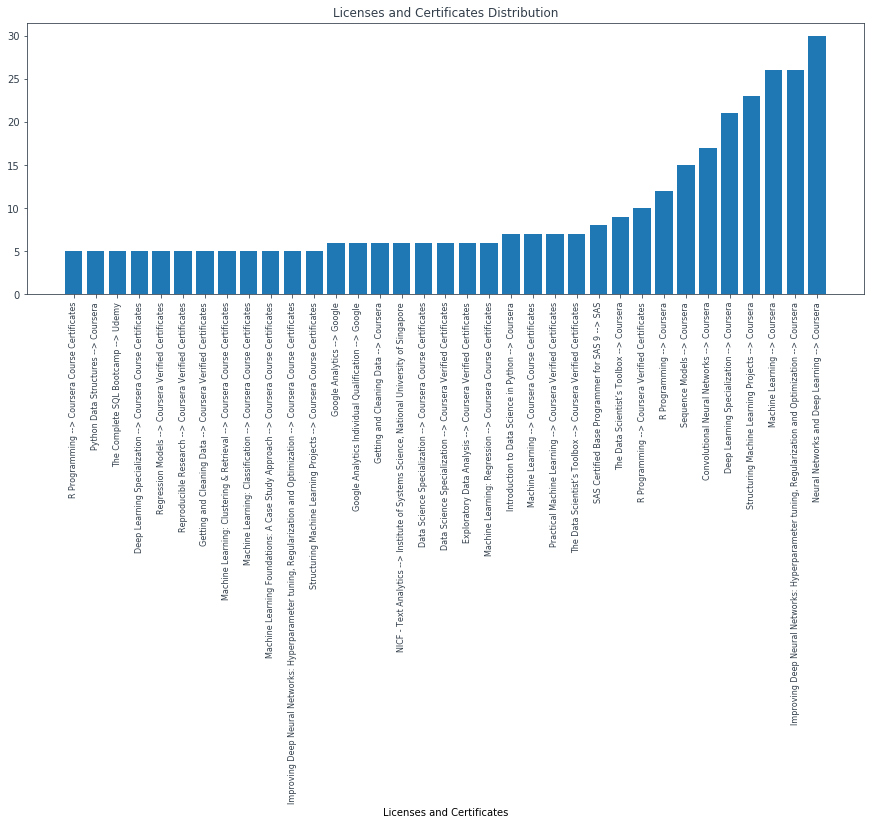

In [80]:
plot_bar_lanc()